In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
from datetime import datetime as dt, timedelta as td

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
# reflect the tables
mapped_tables = Base.metadata.tables.keys()


C:\Users\NTEZA\AppData\Local\Temp\ipykernel_21552\2042882216.py:3: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
print(Base.classes.keys())

['station', 'measurement']


In [7]:
# Save references to each table
tables = {table_name: Base.classes.get(table_name) for table_name in Base.classes.keys()}


In [8]:
# Create our session (link) from Python to the DB
from sqlalchemy.orm import Session
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
Measurement = tables['measurement']

# Query the database to find the most recent date
most_recent_date = session.query(func.max(Measurement.date)).scalar()
# Print the most recent date
print("Most recent date:", most_recent_date)

Most recent date: 2017-08-23


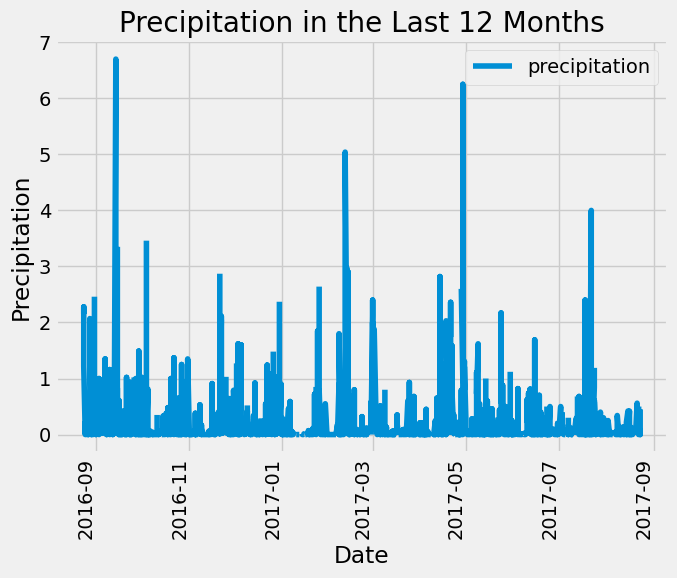

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in dataset
one_year_ago = dt.strptime(most_recent_date, '%Y-%m-%d') - td(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['date', 'precipitation'])

# Convert the date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Sort the dataframe by date
df = df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(7, 6))
df.plot(x='date', y='precipitation', linestyle='-', ax=plt.gca())
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.title('Precipitation in the Last 12 Months')
plt.legend(['precipitation'], loc='upper right')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df['precipitation'].describe()
print("Summary Statistics for Precipitation Data:")
print(summary_statistics)

Summary Statistics for Precipitation Data:
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset

Station = tables['station']

# Perform a query to calculate the total number of stations
total_stations = session.query(func.count(Station.station)).all()

# Print the total number of stations
total_stations


[(9,)]

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station).label('count')) \
                         .group_by(Measurement.station) \
                         .order_by(func.count(Measurement.station).desc()) \
                         .all()

# Print the most active stations and their counts
stations = [(station, count) for station, count in active_stations]
stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Get the most active station ID
most_active_station_id = active_stations[0][0]

# Perform a query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station_id).all()

# Print the temperature statistics in the desired format
print(temperature_stats)

[(54.0, 85.0, 71.66378066378067)]


Text(0.5, 12.583333333333302, 'Temperature')


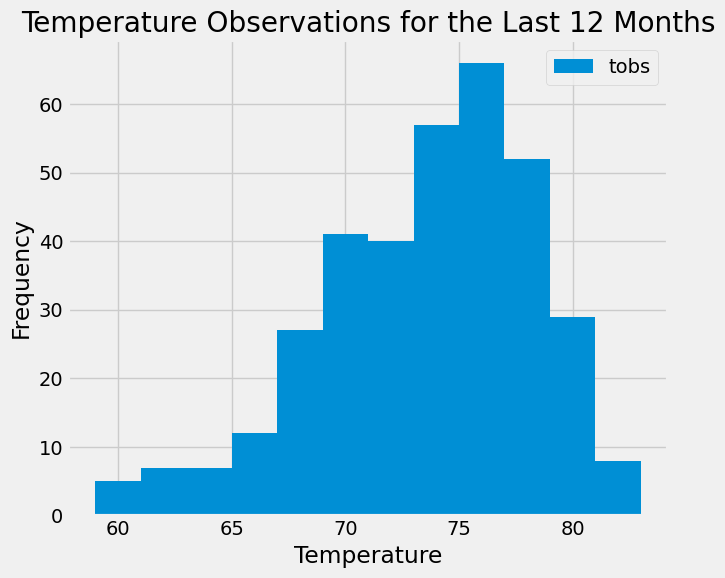

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Perform a query to retrieve the last 12 months of temperature observation data for the most active station
temperature_data = session.query(Measurement.date, Measurement.tobs).filter(
    Measurement.station == most_active_station_id,
    Measurement.date >= one_year_ago
).all()

# Save the query results as a Pandas DataFrame and set the column names
hist_df = pd.DataFrame(temperature_data, columns=['date', 'temperature'])

# Convert the date column to datetime
hist_df['date'] = pd.to_datetime(hist_df['date'])


# Plot the results as a histogram
plt.figure(figsize=(7, 6))
plt.hist(hist_df['temperature'], bins=12)
plt.xlabel('Temperature')
xlabel = plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature Observations for the Last 12 Months')
plt.legend(['tobs'])
plt.tight_layout()
print(xlabel)
plt.show()



# Close Session

In [16]:
# Close Session
session.close()